# Recency,Frequency,Monetary 에 따른 고객 세분화 & 클러스터링 
<hr>

<br>

### 개요
> RFM, 즉 구매횟수,금액,빈도등의 일정 기준에 맞추어 고객을 세분화하고 비지도적 방법인 클러스터링 기법을 통해 새로운 고객그룹을 찾아낸다.

<br>

### RFM?
> RFM이란 아래와 같다.
- Recency(가장 최근 구입 일에서 오늘까지의 시간)
- Frequency(상품 구매 횟수)
- Monetary(총 구매 금액) <br>

> 기업의 입장에서, 현재 자사의 주요 고객층과 잠재적 고객층 등의 고객 분류 작업은 굉장히 중요한 일이다. 적절한 기준에 의해 분류된 고객 그룹들에 대해서 그룹별 Target마케팅을 시도할 수 있으며, 이는 마케팅 효과의 극대화를 이루어낼 수 있다.

<br>

### Segmentation VS Clustering
> 고객 세분화와 군집화는 서로 다른개념이다. 세분화의 경우 마케터가 정한 일정한 '기준'에의한 유사성을 기반으로 고객들을 분류하는것을 의미하며, 군집화는 미리 세워진 기준에 의해 이루어지는것이 아닌, 통계적 방법에 의해 이루어지므로 

<br>

### Data
> 고객 분류하는 요소는 여러 가지가 있다. 지역/결혼 여부/성별/소득과 같은 개인 신상정보에서 부터 고객의 구매이력/선호채널 등의 정보를 활용하여 분류할 수 있다. 기업의 입장에서 더 중요한 분류 요소는 고객이 어떤 상품을 얼마나 많은 비용을 써서 얼마나 자주 사용하는가에 기반한 정보일 것이다. 따라서 여기서는, 고객의 상품 구매이력을 나타내는 RFM데이터에 기반하여 고객분류 및 마케팅 최적화를 진행한다.
RFM 분석을 위해 필요한 데이터는 아래와 같다.
- 식별 또는 비 식별 고객ID
- 구매 일자
- 구매 횟수
- 구매 금액

### <목차>

1. Data Load & Library import
2. Data Check <br>
    2.1 수치형 변수 탐색 <br>
    2.2 1차 데이터 정제 후 데이터 탐색 <br>
    2.3 고객 출신 국가 탐색
3. RFM 기반 데이터 Handling <br>
    3.1 R,F,M 분포 탐색 <br>
    3.2 R,F,M Grouping <br>
    3.3 고객 세그먼테이션
4. 클러스터링을 통한 고객군 탐색

#### 1. Data & Library Load

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import squarify

import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

sns.set()
%matplotlib inline

from matplotlib import font_manager, rc
import matplotlib
#한글 폰트 등록
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

# 원본 데이터 저장
df_ori = pd.read_excel(io='C:/Users/KIHyuk/Desktop/dacon_data/CRM/UCI_Online_Retail/Online Retail.xlsx')

# 복사본으로 진행
df = df_ori.copy()

#### 2. 데이터 체크

In [1]:
print("전체 row 수: ",df.shape[0])
print("전체 column 수: ",df.shape[1])
df.head(3)

NameError: name 'df' is not defined

In [6]:
df.info()

print("Customer ID 결측치 : ",df['CustomerID'].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


<br>

총 541909개의 row와 8개의 컬럼으로 구성되어 있다. 컬럼별 결측값 또한 다수 존재한다. 그 중 CustomerID의 경우 결측값을 채워넣을 방법이 없기 때문에 결측행의 경우 삭제한다. 

<br>


In [8]:
# 결측값을 가진 CustomerID 제외
df = df[df['CustomerID'].notnull()]

#### 수치형 변수에 대한 체크

In [9]:
print(df['Quantity'].describe())
print("#####################")
print(df['UnitPrice'].describe())

count    406829.000000
mean         12.061303
std         248.693370
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64
#####################
count    406829.000000
mean          3.460471
std          69.315162
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: UnitPrice, dtype: float64


<br>

전체 정보 중 수치형 정보를 나타내는 "Quantity"와 "UnitPrice"를 살펴보면, -값이 존재하는것을 확인할 수 있다. 이는 취소 거래를 나타내는것으로 보이며 분석의 효율성을 위해 -값을 제거한 후 진행한다.

<br>

In [10]:
# Quantity, UnitPrice -값 제외
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

#### 1차 데이터 정제 후 데이터 체크

In [11]:
print(df.shape)
print("############")
print(df.isnull().sum())
df.head(3)

(397884, 8)
############
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


<br>

1차 데이터 정제 후 데이터 row수가 541909에서 397884로 줄었음을 확인할 수 있으며 모든 컬럼에서 결측값이 제거되었다.

<br>

#### 고객의 출신국가 정보 체크

In [12]:
print("전체 국가 수 : ",df['Country'].nunique())
df['Country'].value_counts()[:10]

전체 국가 수 :  37


United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1462
Australia           1182
Name: Country, dtype: int64

<br> 

고객 정보 중, 전체 37개국의 고객이 존재하며, 이 중 영국출신의 고객이 대부분을 차지하는것을 확인할 수 있다. 영국 출신의 고객들을 sampling하여 진행한다.

<br>

In [13]:
# United Kingdom출신 고객 추출
df = df[df['Country'] == 'United Kingdom']

#### RFM 기반의 데이터 가공

1차 cleansing을 마친 데이터를 RFM의 정보를 담는 데이터로 변환한다

In [14]:
# 총 결제금액 정보를 담는 'sale_amount' 컬럼을 추가
df['sale_amount'] = df['Quantity'] * df['UnitPrice']

In [15]:
# 개별 고객 기준데이터로 변경

aggregations = {
    "InvoiceDate" : 'max', # 고객별 가장 최근 구매일
    "InvoiceNo" : 'count', # 고객별 구매 횟수 
    "sale_amount" : "sum" # 고객별 구매합계
}

cust_df = df.groupby('CustomerID').agg(aggregations)

cust_df = cust_df.rename(columns={'InvoiceDate':'Recency', 
                                 'InvoiceNo':'Frequency',  
                                 'sale_amount':'Monetary' 
                                 }
                        )

cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346.0,2011-01-18 10:01:00,1,77183.60
1,12747.0,2011-12-07 14:34:00,103,4196.01
2,12748.0,2011-12-09 12:20:00,4595,33719.73


<br>

2가지의 처리를 더 해주어야 한다. <br>
1. float형식인 CustomerID를 object형식으로 변환한다
2. Recency 데이터의 경우 가장 최근 구입 일에서 오늘까지의 시간을 의미함으로, 이에 맞추어 추가적인 변환을 진행한다.

<br>

In [16]:
# CustomerID flot -> object
cust_df['CustomerID'] = cust_df['CustomerID'].astype('object')

# to Recency
import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency'] 
cust_df['Recency'] = cust_df['Recency'].apply(lambda x:x.days+1)

cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


<br>

각 고객Id(식별키)별로 Recency,Frequency,Monetary의 정보를 담는 데이터로 변환이 완료되었다.

<br>

#### Recency, Frequency, Monetary 분포 체크

           Recency    Frequency       Monetary
count  3920.000000  3920.000000    3920.000000
mean     92.742092    90.388010    1864.385601
std      99.533485   217.808385    7482.817477
min       1.000000     1.000000       3.750000
25%      18.000000    17.000000     300.280000
50%      51.000000    41.000000     652.280000
75%     143.000000    99.250000    1576.585000
max     374.000000  7847.000000  259657.300000


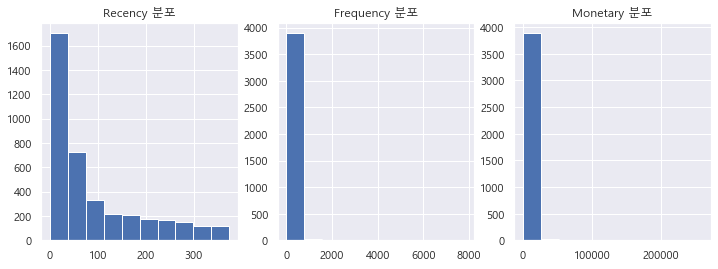

In [17]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4),nrows=1,ncols=3)
ax1.set_title('Recency 분포')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency 분포')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary 분포')
ax3.hist(cust_df['Monetary'])

print(cust_df[['Recency','Frequency','Monetary']].describe())

<br>

R,F,M별로 데이터 분포도 확인결과, 모든 데이터에서 특정 범위에 값이 몰려있는 데이터 왜곡 정도가 매우 심함을 알 수 있다. 이는, 클러스터링 등의 머신러닝 기법을 적용할 경우 결과 왜곡을 발생시킬 가능성이 높으므로 적절한 전처리를 필요로 한다.

<br>

#### R,F,M Grouping

<br> 

R,F,M을 각각 전체 4개의 등급으로 분할하여 Grouping을 진행하며 RFM 전체의 등급을 알수있는 RFM_segment 정보를 추가한다.

<br>

In [18]:
# R , F , M grouping

R_labels = range(4,0,-1)
F_labels = range(1,5)
M_labels = range(1,5)

R_groups = pd.qcut(cust_df['Recency'], q=4, labels=R_labels)
F_groups = pd.qcut(cust_df['Frequency'], q=4, labels=F_labels)
M_groups = pd.qcut(cust_df['Monetary'], q=4, labels=M_labels)

cust_df = cust_df.assign(R=R_groups.values, F=F_groups.values, M=M_groups.values)

# join R,F,M => RFM
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])

cust_df['RFM_segment'] = cust_df.apply(join_rfm,axis=1)

# 61개의 등급
print("등급 개수 : ",cust_df['RFM_segment'].nunique())
print("###############")
cust_df.head(3)

등급 개수 :  61
###############


,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_segment
0,12346,326,1,77183.60,1,1,4,114
1,12747,3,103,4196.01,4,4,4,444
2,12748,1,4595,33719.73,4,4,4,444


<br>

RFM_segment의 정보를 보면, 총 61개의 등급으로 이루어져있는것을 확인할 수 있다. 이 정보를 바탕으로 "최우수","우수","충성","잠재","유망","활성화 필요" 총 7가지의 등급으로 변환한다. 

<br>

In [19]:
# 등급 간소화

cust_df['RFM_score'] = cust_df[['R','F','M']].sum(axis=1)

def rfm_grouping(df):
    if df['RFM_score'] >= 9 : return '특급'
    elif (df['RFM_score'] >= 8) and (df['RFM_score'] < 9) : return "최우수"
    elif (df['RFM_score'] >= 7) and (df['RFM_score'] < 8) : return "우수"
    elif (df['RFM_score'] >= 6) and (df['RFM_score'] < 7) : return "충성"
    elif (df['RFM_score'] >= 5) and (df['RFM_score'] < 6) : return "잠재"
    elif (df['RFM_score'] >= 4) and (df['RFM_score'] < 5) : return "유망"
    else : return "활성화 필요"
    
cust_df['RFM_level'] = cust_df.apply(rfm_grouping,axis=1)

cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_segment,RFM_score,RFM_level
0,12346,326,1,77183.60,1,1,4,114,6.0,충성
1,12747,3,103,4196.01,4,4,4,444,12.0,특급
2,12748,1,4595,33719.73,4,4,4,444,12.0,특급


<br>

고객 등급별 통계량을 살펴보고 시각화를 통해 주요 고객군을 파악할 수 있다.

<br>

In [20]:
aggregations = {
    "Recency" : 'mean', # 고객별 가장 최근 구매일
    "Frequency" : 'mean', # 고객별 구매 횟수 
    "Monetary" : ["mean","count"] # 고객별 구매합계
}

# .sort_values(by='count').round(1)
cust_df.groupby('RFM_level').agg(aggregations).sort_values(by=( 'Monetary', 'count'),ascending=False).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_level                                 
특급           27.3     188.8   3940.5  1520
잠재          154.0      21.0    357.0   470
충성           97.7      28.4    829.5   424
최우수          61.5      55.4    917.1   408
우수           79.1      38.5    733.0   393
유망          175.0      13.7    234.2   362
활성화 필요      258.9       8.1    152.3   343

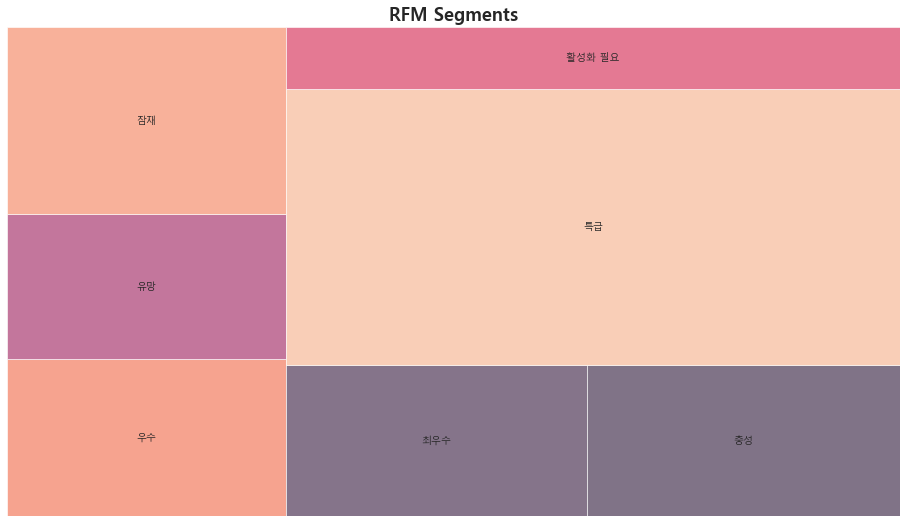

In [21]:
rfm_level_agg = cust_df.groupby('RFM_level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['우수',
                     '유망',
                     '잠재',
                     '최우수',
                     '충성', 
                     '특급', 
                     '활성화 필요'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

<br>

#### 클러스터링을 통한 고객 군집화

<br>

이제, 미리 세워둔 기준에 의한 고객 세분화 방식이 아닌 비지도 학습방식의 클러스터링 기법을 통해 고객군을 파악 및 발굴해 본다.

<br>

앞서 살펴보았듯 Recency,Frequency,Monetary의 분포가 지나치게 한쪽으로 쏠려있다. 데이터 왜곡의 정도가 심한것인데 이 경우 클러스터링 기법을 적용하여도 왜곡된 결과가 나올 가능성이 높다. 따라서 로그변환을 통한 데이터 왜곡 완화를 실시한다.

<br>

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <a list of 10 Patch objects>)

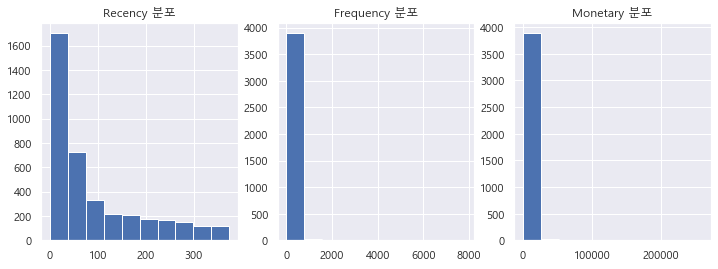

In [28]:
# 왜곡된 데이터 분포

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4),nrows=1,ncols=3)
ax1.set_title('Recency 분포')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency 분포')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary 분포')
ax3.hist(cust_df['Monetary'])

silhouette_score :  0.3033962891425885


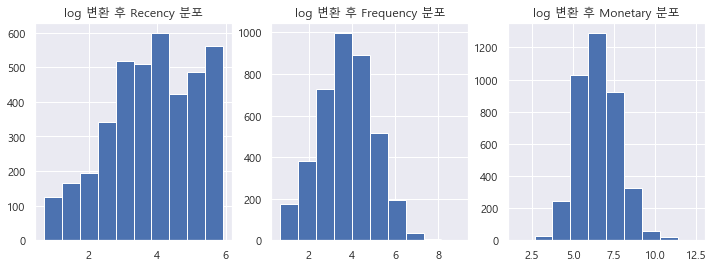

In [31]:
# 데이터 로그변환 및 표준화

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

# log변환
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# 표준화
X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4),nrows=1,ncols=3)
ax1.set_title('log 변환 후 Recency 분포')
ax1.hist(cust_df['Recency_log'])

ax2.set_title('log 변환 후 Frequency 분포')
ax2.hist(cust_df['Frequency_log'])

ax3.set_title('log 변환 후 Monetary 분포')
ax3.hist(cust_df['Monetary_log'])

<br> 

log변환을 통해 데이터의 왜곡이 개선된것을 확인할 수 있다. 이제, 클러스터링 기법을 적용해 본다. <br>

클러스터링 결과에 대한 평가지표로는 "실루엣 분석(sillhouette analysis)을 사용한다. 

<br>

In [ ]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")
        
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

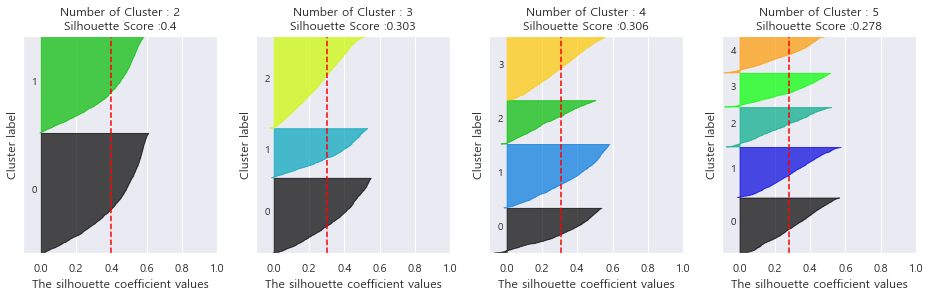

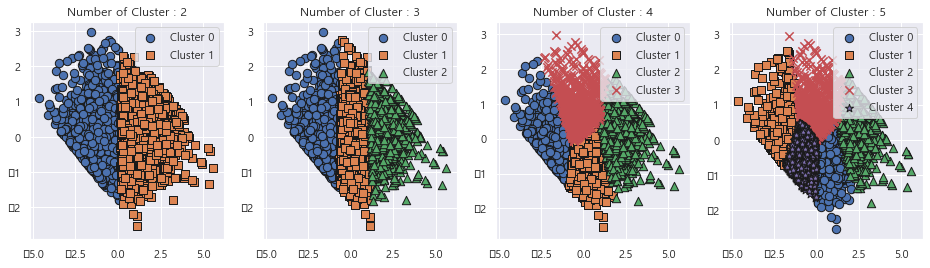

In [34]:
# 클러스터링 갯수에 따른 시각화
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

In [35]:
kmeans = KMeans(n_clusters=4,random_state=0) # 클러스터링 갯수를 3으로 하였을때
labels= kmeans.fit_predict(X_features_scaled)

cust_df['cluster_label'] = labels

print("silhouette_score : ",silhouette_score(X_features_scaled,labels))

silhouette_score :  0.30600621009100515


In [36]:
cust_df

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_segment,RFM_score,RFM_level,Recency_log,Frequency_log,Monetary_log,cluster_label
0,12346,326,1,77183.60,1,1,4,114,6.0,충성,5.789960,0.693147,11.253955,3
1,12747,3,103,4196.01,4,4,4,444,12.0,특급,1.386294,4.644391,8.342128,0
2,12748,1,4595,33719.73,4,4,4,444,12.0,특급,0.693147,8.432942,10.425868,0
3,12749,4,199,4090.88,4,4,4,444,12.0,특급,1.609438,5.298317,8.316760,0
4,12820,4,59,942.34,4,3,3,433,10.0,특급,1.609438,4.094345,6.849427,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915,18280,278,10,180.60,1,1,1,111,3.0,활성화 필요,5.631212,2.397895,5.201806,1
3916,18281,181,7,80.82,1,1,1,111,3.0,활성화 필요,5.204007,2.079442,4.404522,1
3917,18282,8,12,178.05,4,1,1,411,6.0,충성,2.197225,2.564949,5.187665,2
3918,18283,4,756,2094.88,4,4,4,444,12.0,특급,1.609438,6.629363,7.647729,0


In [39]:
# 클러스터 label(0~3)에 따른 통계량

cust_df.groupby(['cluster_label']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean','count'],
}).round(0)

Recency Frequency Monetary      
                 mean      mean     mean count
cluster_label                                 
0                12.0     265.0   5980.0   820
1               200.0      15.0    295.0  1156
2                26.0      30.0    466.0   791
3                88.0      83.0   1471.0  1153

In [40]:
aggregations = {
    "Recency" : 'mean', # 고객별 가장 최근 구매일
    "Frequency" : 'mean', # 고객별 구매 횟수 
    "Monetary" : ["mean","count"] # 고객별 구매합계
}

# .sort_values(by='count').round(1)
cust_df.groupby('RFM_level').agg(aggregations).sort_values(by=( 'Monetary', 'count'),ascending=False).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_level                                 
특급           27.3     188.8   3940.5  1520
잠재          154.0      21.0    357.0   470
충성           97.7      28.4    829.5   424
최우수          61.5      55.4    917.1   408
우수           79.1      38.5    733.0   393
유망          175.0      13.7    234.2   362
활성화 필요      258.9       8.1    152.3   343

In [41]:
# 클러스터 label(0~3)에 따른 통계량

cust_df.groupby(['cluster_label']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean','count'],
}).round(0)

Recency Frequency Monetary      
                 mean      mean     mean count
cluster_label                                 
0                12.0     265.0   5980.0   820
1               200.0      15.0    295.0  1156
2                26.0      30.0    466.0   791
3                88.0      83.0   1471.0  1153